In [1]:
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from numpy.random import randint

In [2]:
# Set random seed for reproducibility
manualSeed = 456
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  456


In [3]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of label classes
n_classes = 10

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = "cpu"
device

device(type='cuda', index=0)

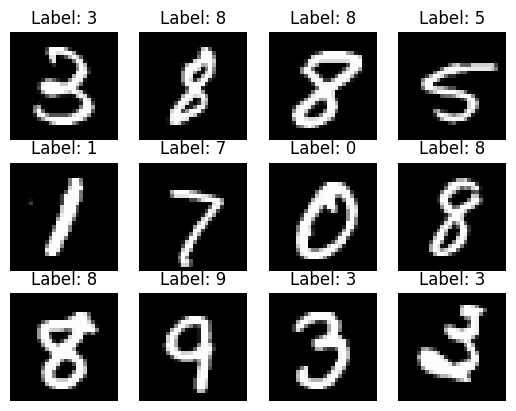

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert PIL Image to Tensor and rescales to [-1, 1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize with mean=0.5, std=0.5
])

# Datasets
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Visualize
examples = iter(dataloader)
images, labels = next(examples)

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator
# input = random vector, output = fake image
class Generator(nn.Module):
    def __init__(self, ngpu, latent_dim=100, n_classes=10):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        # Embedding for categorical input (label)
        self.label_embedding = nn.Embedding(n_classes, 50)  # 10 classes, embedding size = 50

        n_nodes = 7*7
        self.label_dense = nn.Linear(50, n_nodes)  # 50 -> 49

        # Input latent vector (size 100)
        self.latent_to_image_size = nn.Linear(latent_dim, n_nodes*128)  # 100 -> 7*7*128
        self.latent_reshape = nn.Unflatten(dim=1, unflattened_size=(128, 7, 7))
        
        # ReLU
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Upsampling Convolutional layers
        self.upsample1 = nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1)    # 7x7x129 -> 14x14x128
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)    # 14x14x128 -> 28x28x128
        
        # Output layer
        self.output_layer = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)   # 28x28x128 -> 28x28x1


    def forward(self, latent_input, labels):
        label_embed = self.label_embedding(labels)
        label_embed = self.label_dense(label_embed)
        label_embed = label_embed.view(-1, 1, 7, 7) # Reshape

        latent = self.latent_to_image_size(latent_input)
        latent = self.leaky_relu(latent)
        latent = self.latent_reshape(latent)

        x = torch.cat((latent, label_embed), dim=1)     # Concatenate latent and label embed

        # Upsample to 16x16
        x = self.upsample1(x)
        x = self.leaky_relu(x)

        # Upsample to 32x32
        x = self.upsample2(x)
        x = self.leaky_relu(x)

        # Output layer
        x = torch.tanh(self.output_layer(x))

        return x
    
netG = Generator(ngpu=ngpu, latent_dim=nz, n_classes=n_classes).to(device=device)
netG.apply(weights_init)

Generator(
  (label_embedding): Embedding(10, 50)
  (label_dense): Linear(in_features=50, out_features=49, bias=True)
  (latent_to_image_size): Linear(in_features=100, out_features=6272, bias=True)
  (latent_reshape): Unflatten(dim=1, unflattened_size=(128, 7, 7))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (upsample1): ConvTranspose2d(129, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upsample2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output_layer): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [7]:
# Discriminator
# input = image, output = likelihood of image being real
class Discriminator(nn.Module):
    def __init__(self, ngpu, in_shape=(28, 28, 1), n_classes=10):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.in_shape = in_shape
        self.n_classes = n_classes
        
        # Embedding for categorical input (label)
        self.label_embedding = nn.Embedding(n_classes, 50)  # 10 classes, embedding size = 50

        # Fully connected layer to scale up label embedding to match image dimensions
        self.label_dense = nn.Linear(50, in_shape[0] * in_shape[1])  # 50 -> 768

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_shape[2] + 1, 128, kernel_size=3, stride=2, padding=1)  # (C+1) -> 128
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128 -> 128

        # ReLU
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(7*7*128, 1)  # 6272 -> 1

    def forward(self, image, labels):
        label_embed = self.label_embedding(labels)
        label_embed = self.label_dense(label_embed)
        label_embed = label_embed.view(-1, 1, self.in_shape[0], self.in_shape[1]) # Shape: (batch_size, 1, 28, 28)
        
        # Concatenate label embedding with image
        x = torch.cat((image, label_embed), dim=1)  # Shape: (batch_size, C+1, 32, 32)

        # Pass through convolutional layers (downsampling)
        x = self.conv1(x)           # 28x28x2 -> 14x14x128
        x = self.leaky_relu(x)
        x = self.conv2(x)           # 14x14x128 -> 7x7x128
        x = self.leaky_relu(x)

        # Flatten and pass through fully connected layers
        x = self.flatten(x)         # 7x7x128 -> 6272
        x = self.dropout(x)
        x = torch.sigmoid(self.fc(x))  # 6272 -> 1

        return x
    
# Create the Discriminator
netD = Discriminator(ngpu=ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (label_embedding): Embedding(10, 50)
  (label_dense): Linear(in_features=50, out_features=784, bias=True)
  (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=6272, out_features=1, bias=True)
)

In [8]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Training Loop

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Train on real batch of images
        netD.zero_grad()
        # generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
        y = torch.full((images.size(0),), real_label, dtype=torch.float, device=device)     # Generates all 1's

        # Forward pass real batch through Discriminator
        output = netD(images, labels).view(-1)
        errD_real = criterion(output, y)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train on fake batch of images from generator
        noise = torch.randn(images.size(0), nz, device=device)                  # Generate batch of latent vectors and labels
        labels = torch.randint(0, n_classes, (images.size(0), ), device=device)

        fake = netG(noise, labels)
        y.fill_(fake_label)
        # Classify all fake batch with Discriminator
        output = netD(fake.detach(), labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, y)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        netG.zero_grad()
        y.fill_(real_label)
        output = netD(fake, labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, y)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/10][0/469]	Loss_D: 1.3913	Loss_G: 0.7103	D(x): 0.4833	D(G(z)): 0.4852 / 0.4915
[0/10][50/469]	Loss_D: 0.0841	Loss_G: 3.5484	D(x): 0.9585	D(G(z)): 0.0327 / 0.0306
[0/10][100/469]	Loss_D: 0.0123	Loss_G: 5.3533	D(x): 0.9965	D(G(z)): 0.0087 / 0.0059
[0/10][150/469]	Loss_D: 0.0044	Loss_G: 6.4696	D(x): 0.9980	D(G(z)): 0.0023 / 0.0021
[0/10][200/469]	Loss_D: 0.0041	Loss_G: 7.0062	D(x): 0.9974	D(G(z)): 0.0013 / 0.0013
[0/10][250/469]	Loss_D: 0.0034	Loss_G: 7.3410	D(x): 0.9974	D(G(z)): 0.0007 / 0.0009
[0/10][300/469]	Loss_D: 0.0006	Loss_G: 8.3246	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[0/10][350/469]	Loss_D: 0.0006	Loss_G: 8.5184	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[0/10][400/469]	Loss_D: 0.6967	Loss_G: 3.4659	D(x): 0.9997	D(G(z)): 0.3961 / 0.0712
[0/10][450/469]	Loss_D: 1.2671	Loss_G: 0.8336	D(x): 0.5407	D(G(z)): 0.4549 / 0.4501
[1/10][0/469]	Loss_D: 1.4531	Loss_G: 0.8346	D(x): 0.5018	D(G(z)): 0.4971 / 0.4561
[1/10][50/469]	Loss_D: 1.1861	Loss_G: 0.9177	D(x): 0.5578	D(G(z)): 0.4376 / 0.407

In [10]:
torch.save(netG.state_dict(), "./mnist-conditional-gan-model.pt")

tensor(5, device='cuda:0')


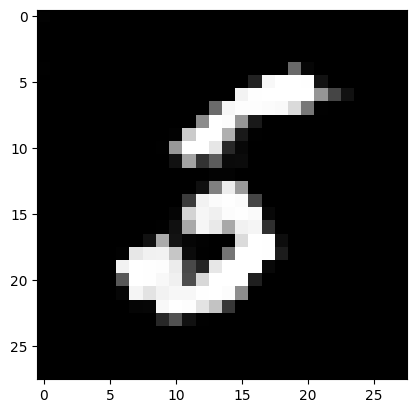

In [53]:
# Set the generator to evaluation mode
netG.eval()

# Generate a sample noise vector
sample_noise = torch.randn(1, nz, device=device)
label = torch.tensor(5, device=device)
print(label)

# Generate an image from the noise vector
X = netG(sample_noise, label).detach().cpu()

# Plot the generated image
plt.imshow(X.view(image_size, image_size), cmap='gray')
plt.show()